In [32]:
%matplotlib inline
import pandas as pd
from pandas import Series
import numpy as np
from functools import reduce
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Lambda
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import array
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import recall_score, precision_score, precision_recall_fscore_support
import sqlite3
import keras
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from numpy.random import seed
from tensorflow import set_random_seed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
data = pd.read_csv("data/orig/cleaned_data_notEncoded.csv")

In [3]:
data['label_away'] = data['label_home'].apply(lambda x: -1 * x)

data['home_won'] = data['label_home'].apply(lambda x: 1 if x == 1 else 0)
data['home_loss'] = data['label_home'].apply(lambda x: 1 if x == -1 else 0)
data['home_draw'] = data['label_home'].apply(lambda x: 1 if x == 0 else 0)

data['away_won'] = data['label_away'].apply(lambda x: 1 if x == 1 else 0)
data['away_loss'] = data['label_away'].apply(lambda x: 1 if x == -1 else 0)
data['away_draw'] = data['label_away'].apply(lambda x: 1 if x == 0 else 0)

In [4]:
match_data = pd.read_csv("data/orig/match_data.csv")
# conn = sqlite3.connect('database.sqlite')
# res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
# match_data = pd.read_sql_query("SELECT * FROM Match", conn)

In [5]:
relevant_match_data = match_data[['season', 'match_api_id', 'date', 'home_team_api_id', 'away_team_api_id']]

In [6]:
data_with_season_date = pd.merge(data, relevant_match_data, on='match_api_id')

In [7]:
grouped_home = data_with_season_date.groupby(['season', 'home_team_api_id'])

In [8]:
names = []
groups = []
for name, group in grouped_home:
    names += [name]
    groups += [group]
#     print(name)
#     print(group.shape)

In [9]:
new_groups = []
for i in range(len(groups)):
    df = groups[i]
    name = names[i]
    df['home_win_record'] = df['home_won'].cumsum() - (df['home_won'].cumsum() > 0)
    df['home_loss_record'] = df['home_loss'].cumsum() - (df['home_loss'].cumsum() > 0)
    df['home_draw_record'] = df['home_draw'].cumsum() - (df['home_draw'].cumsum() > 0)
    df['season'] = name[0]
    df['home_team_api_id'] = name[1]
    new_groups += [df]

In [10]:
df_home_stats = pd.concat(new_groups)

In [11]:
df_home_stats[['label_home', 'home_win_record']].head()

,label_home,home_win_record
3971,1.0,0
3984,1.0,1
3999,1.0,2
4013,-1.0,2
4027,0.0,2


In [12]:
df_home_stats.columns.values

array(['home_player_X1', 'home_player_X2', 'home_player_X3',
       'home_player_X4', 'home_player_X5', 'home_player_X6',
       'home_player_X7', 'home_player_X8', 'home_player_X9',
       'home_player_X10', 'home_player_X11', 'home_player_Y1',
       'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'home_buildUpPlaySpeed',
       'home_buildUpPlayDribbling', 'home_buildUpPlayPassing',
       'home_chanceCreationPassing', 'home_chanceCreationCrossing',
       'home_chanceCreationShooting', 'home_defencePressure',
       'home_defenceAggression', 'home_defenceTeamWidth',
       'home_player_1_overall_rating', 'home_player_1_potential',
       'home_player_1_preferred_foot',
       'home_player_1_attacking_work_rate',
       'home_player_1_defensive_work_rate', 'home_player_1_crossing',
       'home_player_1_finishing', 'home_player_1_

In [13]:
grouped_away = df_home_stats.groupby(['season', 'away_team_api_id'])

In [14]:
names = []
groups = []
for name, group in grouped_away:
    names += [name]
    groups += [group]
#     print(name)
#     print(group.shape)
# print(names[4])
# groups[1]

In [15]:
new_groups = []
for i in range(len(groups)):
    df = groups[i]
    name = names[i]
    df['away_win_record'] = df['away_won'].cumsum() - (df['away_won'].cumsum() > 0)
    df['away_loss_record'] = df['away_loss'].cumsum() - (df['away_loss'].cumsum() > 0)
    df['away_draw_record'] = df['away_draw'].cumsum() - (df['away_draw'].cumsum() > 0)
    df['season'] = name[0]
    df['away_team_api_id'] = name[1]
    new_groups += [df]

In [16]:
df_final = pd.concat(new_groups)

In [17]:
df_final.shape

(20060, 917)

In [18]:
df_final.columns.values

array(['home_player_X1', 'home_player_X2', 'home_player_X3',
       'home_player_X4', 'home_player_X5', 'home_player_X6',
       'home_player_X7', 'home_player_X8', 'home_player_X9',
       'home_player_X10', 'home_player_X11', 'home_player_Y1',
       'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'home_buildUpPlaySpeed',
       'home_buildUpPlayDribbling', 'home_buildUpPlayPassing',
       'home_chanceCreationPassing', 'home_chanceCreationCrossing',
       'home_chanceCreationShooting', 'home_defencePressure',
       'home_defenceAggression', 'home_defenceTeamWidth',
       'home_player_1_overall_rating', 'home_player_1_potential',
       'home_player_1_preferred_foot',
       'home_player_1_attacking_work_rate',
       'home_player_1_defensive_work_rate', 'home_player_1_crossing',
       'home_player_1_finishing', 'home_player_1_

In [19]:
df_final['season'].values

array(['2008/2009', '2008/2009', '2008/2009', ..., '2015/2016',
       '2015/2016', '2015/2016'], dtype=object)

In [20]:
df_final['season'] = pd.factorize(df_final['season'])[0]

In [21]:
df_final = df_final.drop(columns=['label_away', 'home_won', 'home_loss', 'home_draw',
                                  'away_won', 'away_loss', 'away_draw', 'date'])

In [22]:
desired_columns = ['season', 'home_win_record', 'home_loss_record', 'home_draw_record',
                  'away_win_record', 'away_loss_record', 'away_draw_record']

for i in range(1, 12):
    for status in ['home_player', 'away_player']:
        posX_name = status + '_X' + str(i)
        posY_name = status + '_Y' + str(i)
        
        rating_name = status + '_' + str(i) + '_' + 'overall_rating'
        desired_columns.extend([posX_name, posY_name, rating_name])

df_rel = df_final[desired_columns]
df_rel.columns.values

array(['season', 'home_win_record', 'home_loss_record',
       'home_draw_record', 'away_win_record', 'away_loss_record',
       'away_draw_record', 'home_player_X1', 'home_player_Y1',
       'home_player_1_overall_rating', 'away_player_X1', 'away_player_Y1',
       'away_player_1_overall_rating', 'home_player_X2', 'home_player_Y2',
       'home_player_2_overall_rating', 'away_player_X2', 'away_player_Y2',
       'away_player_2_overall_rating', 'home_player_X3', 'home_player_Y3',
       'home_player_3_overall_rating', 'away_player_X3', 'away_player_Y3',
       'away_player_3_overall_rating', 'home_player_X4', 'home_player_Y4',
       'home_player_4_overall_rating', 'away_player_X4', 'away_player_Y4',
       'away_player_4_overall_rating', 'home_player_X5', 'home_player_Y5',
       'home_player_5_overall_rating', 'away_player_X5', 'away_player_Y5',
       'away_player_5_overall_rating', 'home_player_X6', 'home_player_Y6',
       'home_player_6_overall_rating', 'away_player_X6', 'away_pl

In [23]:
df_rel.shape

(20060, 73)

In [24]:
df_label = df_final['label_home']
df_label.shape

(20060,)

In [25]:
X = df_rel.values
y = df_label.values

In [26]:
y = [i + 1 for i in y]
y = array(y)
y = to_categorical(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) 
y.shape

(20060, 3)

In [27]:
def recall(y_true, y_pred):
    print(type(y_true))
    print(tf.keras.backend.get_value(y_true))
    recall_vals = recall_score(y_true, y_pred, average=None)
    recall_vals = tf.convert_to_tensor(recall_vals, dtype=tf.float32)
    return recall_vals



In [42]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def createToyModel(input_dim):
    
    xavier_init = glorot_normal(seed=54)
    model = Sequential()
    model.add(Dense(units=27, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=18, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=9, activation='elu', kernel_initializer=xavier_init))
    model.add(Dense(units=3, activation='softmax', kernel_initializer=xavier_init))
    decay_rate = 3e-4 / 30
    opt = Adam(lr=3e-4)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model


In [43]:
seed(5)
set_random_seed(10)
model = createToyModel(X_train.shape[1])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
history = model.fit(X_train, y_train, callbacks=[reduce_lr], validation_data=(X_test, y_test), 
          batch_size=8, shuffle=True, epochs=50)

Train on 18054 samples, validate on 2006 samples
Epoch 1/50
18054/18054 [==============================] - 6s 351us/step - loss: 1.1175 - acc: 0.4371 - val_loss: 1.1284 - val_acc: 0.3744
Epoch 2/50
18054/18054 [==============================] - 7s 412us/step - loss: 1.0376 - acc: 0.4754 - val_loss: 1.0485 - val_acc: 0.4706
Epoch 3/50
18054/18054 [==============================] - 8s 426us/step - loss: 1.0021 - acc: 0.5023 - val_loss: 1.0777 - val_acc: 0.4925
Epoch 4/50
18054/18054 [==============================] - 7s 413us/step - loss: 0.9775 - acc: 0.5255 - val_loss: 1.0192 - val_acc: 0.4970
Epoch 5/50
18054/18054 [==============================] - 8s 464us/step - loss: 0.9605 - acc: 0.5372 - val_loss: 0.9669 - val_acc: 0.5204
Epoch 6/50
18054/18054 [==============================] - 7s 394us/step - loss: 0.9535 - acc: 0.5439 - val_loss: 1.0376 - val_acc: 0.4796
Epoch 7/50
18054/18054 [==============================] - 7s 386us/step - loss: 0.9415 - acc: 0.5569 - val_loss: 0.9522 - v

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


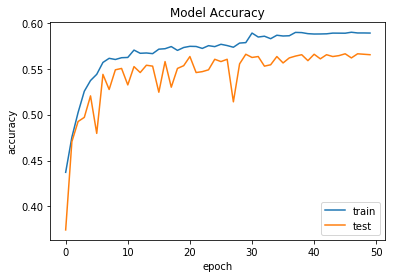

In [44]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


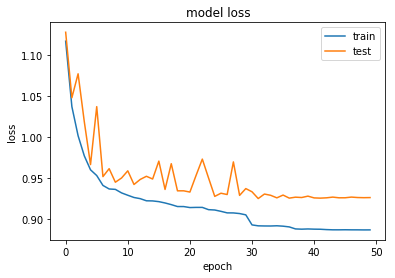

In [45]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Be careful about overwriting weights in the cell below

In [ ]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
from tensorflow import set_random_seed
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(X_train, np.argmax(y_train, axis=1))

seed(5)
set_random_seed(10)
val_loss = []
val_acc = []
for i,f in enumerate(folds):
    fpath = 'seung_best'+str(i)+'.h5' # change me
    checkpoint = ModelCheckpoint(fpath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    train = f[0]
    val = f[1]

    X_fold_train, y_fold_train = X_train[train], y_train[train]
    X_fold_val, y_fold_val = X_train[val], y_train[val]
    
    model = createToyModel(X_train.shape[1])
    model.fit(x=X_fold_train, y=y_fold_train, batch_size=8, shuffle=True, epochs=30, 
    validation_data=(X_fold_val, y_fold_val), callbacks=callbacks_list)
    
    model.load_weights(fpath)
    loss, acc = model.evaluate(X_fold_val, y_fold_val)
    val_loss.append(loss)
    val_acc.append(acc)

In [ ]:
print('Val losses:', val_loss)
print('Val accs:', val_acc)
print('Avg. val acc', np.mean(val_acc))

# Load and evaluate

In [ ]:
train_loss = []
train_acc = []
predicted = []
model = createToyModel(X_train.shape[1])
model.fit(x=X_fold_train, y=y_fold_train, batch_size=8, shuffle=True, epochs=1, 
    validation_data=(X_fold_val, y_fold_val), callbacks=callbacks_list)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(X_train, np.argmax(y_train, axis=1))
for i,f in enumerate(folds):
    fpath = 'fixed_best'+str(i)+'.h5' # CHANGE ME
    train = f[0]
    val = f[1]

    X_fold_train, y_fold_train = X_train[train], y_train[train]
    X_fold_val, y_fold_val = X_train[val], y_train[val]

    
    
    model.load_weights(fpath)
    loss, acc = model.evaluate(X_fold_train, y_fold_train)
    y_pred = model.predict(x=X_test)
    predicted.append(y_pred)
    train_loss.append(loss)
    train_acc.append(acc)

In [ ]:
print(np.mean(np.array(val_acc) - np.array(train_acc)))

In [ ]:
df = pd.DataFrame(index=pd.Index(['Model ' + str(i) for i in range(5)] + ['Ensemble averaging']), columns=['precision', 'recall', 'f1', 'accuracy']).fillna(0)
for i, p in enumerate(predicted):
    p_score, r_score, f1_score, _ = precision_recall_fscore_support(y_test, one_hot(np.argmax(p, axis=1).astype(int), 3), average='weighted')
    acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(p, axis=1))
    df.loc['Model ' +str(i), 'precision'] = p_score
    df.loc['Model ' +str(i), 'recall'] = r_score
    df.loc['Model ' +str(i), 'f1'] = f1_score
    df.loc['Model ' +str(i), 'accuracy'] = acc
df

In [ ]:
# normalize predictions for all models
predicted_arr = np.array(predicted)
# for i in range(5):
#     for j in range(predicted_arr.shape[1]):
#         predicted_arr[i, j, :] /= np.linalg.norm(predicted_arr[i, j, :] )

In [ ]:
predicted_mean = np.mean(predicted_arr, axis=0)

In [ ]:
# plt.figure()
# plt.hist(np.argmax(predicted_mean, axis=1), color='r', alpha=0.5, label='pred')
# plt.hist(np.argmax(y_test, axis=1), color='yellow', alpha=0.3, label='true')
p_score, r_score, f1_score, _ = precision_recall_fscore_support(y_test, one_hot(np.argmax(predicted_mean, axis=1).astype(int), 3), average='weighted')
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_mean, axis=1))
df.loc['Ensemble averaging', 'precision'] = p_score
df.loc['Ensemble averaging', 'recall'] = r_score
df.loc['Ensemble averaging', 'f1'] = f1_score
df.loc['Ensemble averaging', 'accuracy'] = acc

# df.to_csv('deeper_prediction_scores.csv') # BE CAREFUL ABOUT OVERWRITING
df

In [ ]:
# odds = pd.read_csv('odds.csv')